In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import os
import random
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [2]:
def read_dataset(cls, data_root='Datasets/IMDB/'):
    data = []
    path = data_root + cls + '/'
    for label in ['pos', 'neg']:
        folder = path + label + '/'
        for f in os.listdir(folder):
            with open(folder+f, 'rb') as file:
                raw_data = file.read().decode('utf-8').replace('\n', ' ').lower()   # use gdk code will throw error
                data.append([raw_data, 1 if label == "pos" else 0])
    
    random.shuffle(data)
    return data

In [3]:
random.seed(42)

train_data, test_data = read_dataset('train'), read_dataset('test')     # list of [sentence, label]
print('number of sentences: ',len(train_data), len(test_data))
print('list of [sentence, label]: ',len(train_data[0]), len(test_data[0]))

# get tks
train_counter = dict(collections.Counter([tk for st, _ in train_data for tk in st.split()]))
train_counter_filtered = dict(sorted(filter(lambda x:x[1]>=5, train_counter.items()), key=lambda x:x[1]))
print(len(train_counter))
print(len(train_counter_filtered))

# cause number decreased a lot, we use filtered data
# mapping tks from/to integers
itos = {i+1:s for i, (s, _) in enumerate(train_counter_filtered.items())}
itos[0] = '<unk>' 
stoi = {s:i for i, s in itos.items()}

number of sentences:  25000 25000
list of [sentence, label]:  2 2
251637
46157


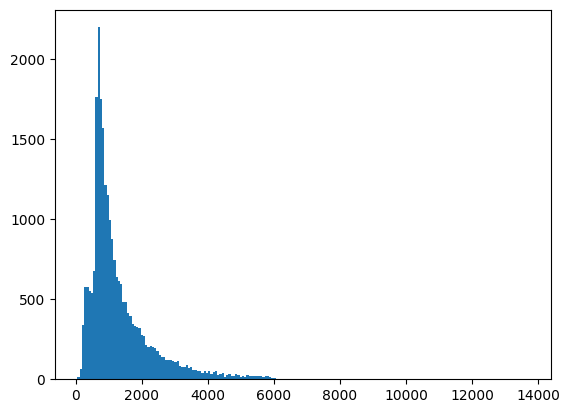

<Figure size 1000x400 with 0 Axes>

mean length : 1325.06964
mid length(approximately): 802


In [4]:
# preprocess data
# extend || cut sentences to fixed length   (according to the figure, we chose 800)
# shape of list : (25000, [800, 1])
length_list = [len(st) for st, label in train_data]
plt.hist(length_list, bins=200); plt.figure(figsize=(10, 4))
plt.show()
print(f'mean length : {sum(length_list)/len(length_list)}')
print(f'mid length(approximately): {length_list[int(len(length_list)/2)]}')

In [23]:
list_X, list_y = [], []
for data, label in train_data:
    X = [stoi[tk] for tk in data.split() if tk in stoi]  # if words don't exist in vocab, else ignore it 
    if len(X) < 800:
        X = X + [0] * (800 - len(X))
    else:
        X = X[:800]
    
    list_X.append(X)
    list_y.append(label)

train_X, train_y = torch.tensor(list_X, dtype=torch.long, device="cuda" if torch.cuda.is_available() else "cpu"), torch.tensor(list_y, dtype=torch.long, device="cuda" if torch.cuda.is_available() else "cpu")
print(train_X.shape)
print(train_y.shape)

torch.Size([25000, 800])
torch.Size([25000])


# Build rnn and train it

In [24]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, vocab_dims, num_hidden, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_dims)   # (num_steps, batch_size, vocab_dims)
        self.lstm = nn.LSTM(vocab_dims, num_hidden, num_layers=num_layers, bidirectional=True)  # (batch_size, 2 * num_hidden)
        self.linear = nn.Linear(4 * num_hidden, 2)  # (batch_size, 2)
    
    def forward(self, x):   # (num_steps, batch_size)
        x = self.embedding(x)  # (num_steps, batch_size, vocab_dims)
        outputs, _ = self.lstm(x)   # outputs (num_steps, batch_size, 2 * num_hidden) 
        logits = self.linear(torch.cat((outputs[0], outputs[-1]), dim=1))   # (batch_size, 2)
        return logits

In [35]:
torch.manual_seed(42)
torch.cuda.empty_cache()

num_epochs = 4000
batch_size = 64
num_hidden = 100
num_layers = 2
vocab_dims = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = len(stoi)
net = BiRNN(vocab_size, vocab_dims, num_hidden, num_layers)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

net.to(device)
loss.to(device)

# for p in net.parameters():
#     p.data *= 0.01

lossi = []
for epoch in range(num_epochs):
    # get batch 
    idx = torch.randint(0, train_X.shape[0], (batch_size, ))
    X, y = train_X[idx].to(device), train_y[idx].to(device) # X (64, 800), y (64)
    X = X.permute(1, 0) # [800, 64]
    
    # forward pass
    logits = net(X) # [64, 2]
    l = loss(logits, y)
    
    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()
    
    # track stats
    lossi.append(l.item())
    if epoch % 200 == 0:
        print(f'epoch {epoch:5d}, loss {l.item() :10f}')

print(f'epoch {epoch:5d}, loss {l.item() :10f}')

epoch     0, loss   0.692877
epoch   200, loss   0.495442
epoch   400, loss   0.235237
epoch   600, loss   0.099837
epoch   800, loss   0.108804
epoch  1000, loss   0.235082
epoch  1200, loss   0.040027
epoch  1400, loss   0.097948
epoch  1600, loss   0.015191
epoch  1800, loss   0.023497
epoch  2000, loss   0.009616
epoch  2200, loss   0.007658
epoch  2400, loss   0.018228
epoch  2600, loss   0.014454
epoch  2800, loss   0.028731
epoch  3000, loss   0.017887
epoch  3200, loss   0.038262
epoch  3400, loss   0.015176
epoch  3600, loss   0.065269
epoch  3800, loss   0.006846
epoch  3999, loss   0.009397


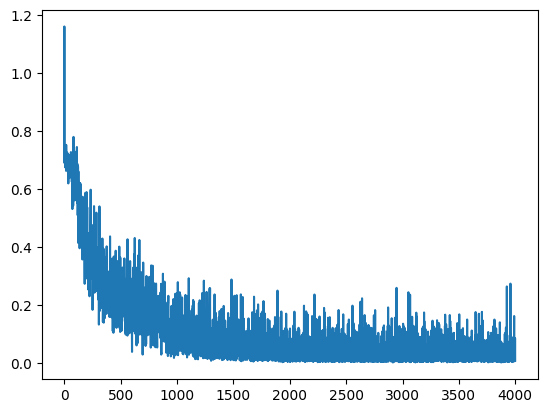

In [36]:
plt.plot(lossi)
plt.show()

In [37]:
torch.save(net.state_dict(), 'Parameters/BiRNN.pt') # save our model parameters 

# Test model

In [41]:
def sentimental_analysis(sentence, net):
    X = torch.tensor([stoi[tk] if tk in stoi else 0 for tk in sentence.split()], dtype=torch.long, device="cuda" if torch.cuda.is_available() else "cpu").view(-1, 1)
    logits = net(X)
    probs = F.softmax(logits, dim=1)
    return 'positive' if torch.argmax(probs).item() == 1 else 'negative' 

print(sentimental_analysis('fuck this stupid movie', net))
print(sentimental_analysis('i love this movie', net))

negative
positive
